# Worksheet 10: Errors in Inference

#### Lecture and Tutorial Learning Goals:
After completing this week's lecture and tutorial work, you will be able to:

1. Define type I & II errors.
2. Describe responsible use and reporting of p-values from hypothesis tests.
3. Discuss how these errors are linked to a "reproducibility crisis".
4. Measure how these errors amplify when performing multiple hypothesis testing, in the context of multiple comparisons.

In [1]:
# Run this cell before continuing.
library(tidyverse)
library(datateachr)
library(repr)
library(digest)
library(infer)
library(grid)
library(gridExtra)
penguins <- read.csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv")
source("tests_worksheet_10.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘infer’ was built under R version 4.0.2”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The f

## 1. Short Recap & Warm-Up

Before we start exploring the new material for this week, let's remind ourselves of some of the most important points covered in the previous week.

**Question 1.1**
<br>{points: 1}

You wanted to test $H_0: \mu = 10$ vs $H_1: \mu\neq 10$. You collected a sample of size 40, and obtained $\bar{x} = 11$ and $s = 1.7$. What is the correct test statistic and 95% confidence interval for the mean?

A. $T = 0.5882$  and $CI(\mu, 0.95) = [10.4563; 11.5437]$

B. $T = 0.5882$  and $CI(\mu, 0.95) = [9.4563; 10.5437]$

C. $T = 0.5882$  and $CI(\mu, 0.95) = [6.5614; 13.4386]$

D. $T = 3.7203$  and $CI(\mu, 0.95) = [10.4563; 11.5437]$

E. $T = 3.7203$  and $CI(\mu, 0.95) = [9.4563; 10.5437]$

F. $T = 3.7203$  and $CI(\mu, 0.95) = [6.5614; 13.4386]$

_Assign your answer to an object called `answer1.1`. Your answer should be a single character surrounded by quotes._

In [2]:
# answer1.1 <- ...

### BEGIN SOLUTION
answer1.1 <- "D"
### END SOLUTION

In [3]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br>{points: 1}

True or false?

You want to test $H_0: \mu = \mu_0$ vs $H_1: \mu \neq \mu_0$. You apply the CLT to approximate the null model. Using the null model, you can do both, test the hypothesis and obtain the confidence interval for the mean $\mu$. 


_Assign your answer to an object called `answer1.2`. Your answer should be either "true" or "false", surrounded by quotes._

In [4]:
# answer1.2 <- ...

### BEGIN SOLUTION
answer1.2 <- "false"
### END SOLUTION

In [5]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br>{points: 1}

If the condition of the CLT hold, what would be distribution of the following quantity:
$$
\frac{\bar{X}-\mu }{s\left/\sqrt{n}\right.}
$$

A. $N\left(\mu, \sigma\left/\sqrt{n}\right.\right)$

B. $N(0, 1)$

C. $t_n$

D. $t_{n-1}$

_Assign your answer to an object called `answer1.3`. Your answer should be a single character surrounded by quotes._

In [6]:
# answer1.3 <- ...

### BEGIN SOLUTION
answer1.3 <- "D"
### END SOLUTION

In [7]:
test_1.3()

[1] "Success!"


## 2. Errors in Hypothesis Testing


To discuss the error types, we will work on scenarios for which we know the truth. Since we never know, with certainty, which of the two hypotheses is true in real cases, we will simulate our data. Let us generate the data of three different populations. 

population,variable
<chr>,<dbl>
pop1,7.01858360
pop2,0.21080649
pop3,0.00000000
pop1,9.73387834
pop2,0.00856461
pop3,0.00000000


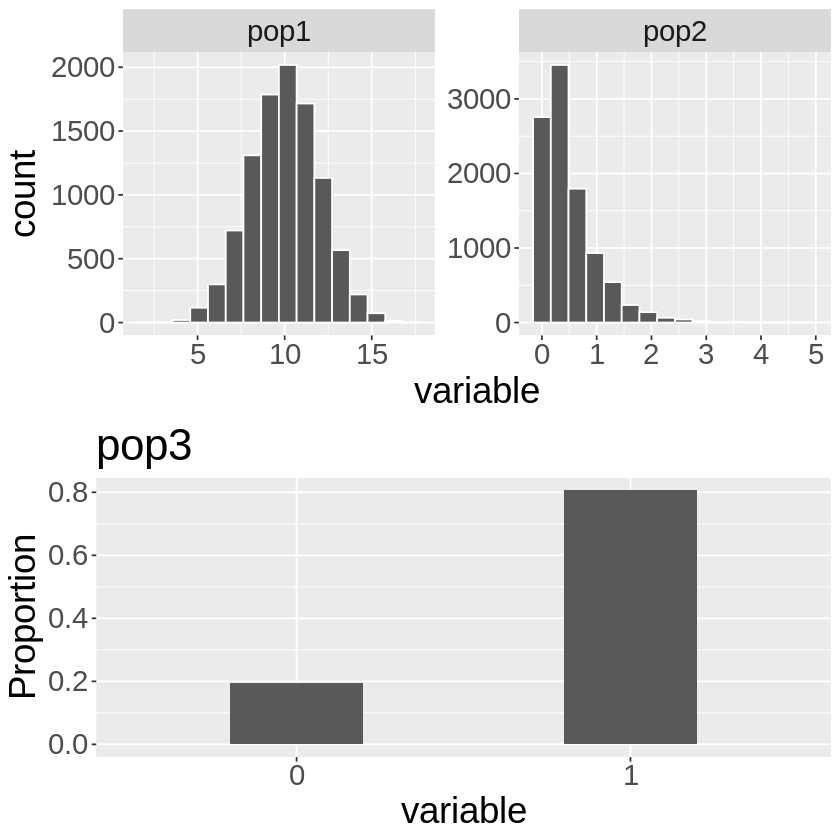

In [8]:
# Run this cell before continuing.....

set.seed(20210322) # Do not change this.

pop1_mu = 10
pop1_sigma = 2
pop2_mu = 0.5
pop3_prop = 0.8

N <- 10000 #population size
pops <- # Generate three different populations
    tibble(pop1 = rnorm(N, pop1_mu, pop1_sigma),
           pop2 = rexp(N, 1/pop2_mu),
           pop3 = sample(c(0, 1), size = N, prob = c(1-pop3_prop, pop3_prop), replace = TRUE)) %>% 
    pivot_longer(starts_with("pop"), names_to = "population", values_to = "variable")

pop_plots <- list() # list to store plots
pop_plots[[1]] <- # plot of the quantitative populations;
    pops %>% 
    filter(population %in% c("pop1", "pop2")) %>% 
    ggplot() + 
    geom_histogram(aes(x = variable), color = 'white', bins = 16) +
    facet_wrap(~population, scales = "free") +
    theme(text = element_text(size = 22))

pop_plots[[2]] <- # plot of the categorical population
    pops %>% 
    filter(population == 'pop3') %>%
    mutate(variable = factor(variable)) %>% 
    ggplot() +
    geom_bar(aes(x = variable, y = ..count../sum(..count..)), width = 0.4) + 
    theme(text = element_text(size = 22)) + 
    ggtitle("pop3") +
    ylab("Proportion")

# show a piece of the populations
head(pops)

# plot the quantitative population in row 1 and categorical population in row 2
grid.arrange(pop_plots[[1]], pop_plots[[2]], nrow = 2) 



Since we have the populations stored in the object `pops`, we can calculate the population parameters.

In [9]:
# show you the parameters of the population
(pops_params <-
    pops %>% 
    group_by(population) %>%
    summarise(pop_mean = mean(variable), pop_sd = sd(variable), .groups = 'drop'))

population,pop_mean,pop_sd
<chr>,<dbl>,<dbl>
pop1,10.0271932,1.9991559
pop2,0.4995928,0.4967339
pop3,0.8063000,0.3952163


### 2.1 Type I Error

The Type I Error is the probability of rejecting $H_0$ when $H_0$ is true. This probability is what we call significance level (or, $\alpha$-level). When we are testing hypotheses, we define a significance level that we are comfortable with. Different problems have different "costs" of Type I Error, making this a problem-dependent specification. For example,

1. Finding an innocent person guilty is a serious error. We should send people to prison only if there is evidence beyond "reasonable doubt" they are guilty. Rejecting the hypothesis that somebody is not guilty when they are indeed not guilty should never happen (ideally). But, this might be impossible. So we desire a very low significance level to commit this error with very low probability. 

2. An oil company is trying to decide if it should start a new digging site to find oil. They will only do that if there is evidence that there is oil in that region. However, creating a digging site is relatively cheap for the company, especially compared with the gains of finding oil. Therefore, the company might be willing to accept a high probability of mistakenly digging a new site when there is no oil in that region. In this situation, the company could use a much higher $\alpha$ (e.g., 0.5) than the usual 0.9, 0.95, or 0.99. 

**Question 2.1.1**
<br>{points: 1}

If we take a sample of size 50 of population one, what is the sampling distribution of test statistic $\frac{\bar{X}-10.0271932}{1.9991559\left/\sqrt{50}\right.}$?

A. $N(10.0271932, 1.9992)$

B. $N(10.0271932, 0.2827)$

C. $t_{49}$

D. $t_{50}$

E. $t_{60}$

_Assign your answer to an object called `answer2.1.1`. Your answer should be a single character surrounded by quotes._

In [10]:
# answer2.1.1 <- ...

### BEGIN SOLUTION
answer2.1.1 <- "C"
### END SOLUTION

In [11]:
test_2.1.1()

[1] "Success!"


**Question 2.1.2**
<br>{points: 1}

Suppose we want to test $H_0: \mu_1 = 10.0271932$ vs $H_1: \mu_1 \neq 10.0271932$, where $\mu_1$ is the mean of population one. Which of the hypotheses is true?

A. $H_0$ is true.

B. $H_A$ is true.

_Assign your answer to an object called `answer2.1.2`. Your answer should be a single character surrounded by quotes._

In [12]:
# answer2.1.2 <- ...

### BEGIN SOLUTION
answer2.1.2 <- "A"
### END SOLUTION

In [13]:
test_2.1.2()

[1] "Success!"


**Question 2.1.3**
<br>{points: 1}

If we take a sample of size 50 of population one, what is the null model of the test statistic $\frac{\bar{X}-10.0271932}{1.9991559\left/\sqrt{50}\right.}$?

A. $N(10.0271932, 1.9992)$

B. $N(10.0271932, 0.2827)$

C. $N(0, 1)$

D. $t_{59}$

E. $t_{60}$

_Assign your answer to an object called `answer2.1.3`. Your answer should be a single character surrounded by quotes._

In [14]:
# answer2.1.3 <- ...

### BEGIN SOLUTION
answer2.1.3 <- "C"
### END SOLUTION

In [15]:
test_2.1.3()

[1] "Success!"


**Question 2.1.4**
<br>{points: 1}

True or false?

The `null model` and the actual sampling distribution of $\frac{\bar{X}-10.0271932}{1.9991559\left/\sqrt{50}\right.}$ are the same.

_Assign your answer to an object called `answer2.1.4`. Your answer should be either "true" or "false", surrounded by quotes._

In [16]:
# answer2.1.4 <- ...

### BEGIN SOLUTION
answer2.1.4 <- "true"
### END SOLUTION

In [17]:
test_2.1.4()

[1] "Success!"


**Question 2.1.5** 
<br> {points: 1}

Now that we know that $H_0$ is true let's measure the chance of rejecting $H_0$. 
Your job is to:

1. Take multiple samples, say 5000, of size $n=50$ from each population;
2. Calculate the sample mean for each sample (in this exercise, we are going to assume we know $\sigma$);
3. Calculate the test statistic;
4. For each significance level $\alpha = (1\%, 5\%, 10\%)$ and each sample, decide if you would reject or not $H_0$ (`TRUE` or `FALSE`).
5. Calculate the proportion of samples that led to the rejection of $H_0$ for each $\alpha$ in each population.

---------------------
```r
set.seed(20210322) # Do not change this.
n <- 50 # Do not change this.

answer2.1.5 <- 
    pops_params$population %>% 
    map_df(~pops %>% 
            filter(population == .x) %>% 
            rep_sample_n(size = n, reps = 5000)) %>% 
    group_by(..., ...) %>% 
    summarise(sample_mean = ..., 
              .groups = 'drop') %>% 
    left_join(pops_params) %>% 
    mutate(test_statistic = ...) %>% 
    crossing(tibble(alpha = c(0.01, 0.05, 0.1))) %>% 
    mutate(reject_h0 = ...) %>% 
    group_by(..., ...) %>% 
    summarise(proportion_rejection = ...)
``` 

Now, compare $\alpha$ with the `proportion_rejection`. What do you see? You do not need to write it down.

_Assign your data frame to an object called `answer2.1.5`._

In [18]:
set.seed(20210322) # Do not change this.
n <- 50 # Do not change this.

### BEGIN SOLUTION
answer2.1.5 <- 
    pops_params$population %>% 
    map_df(~pops %>% filter(population == .x) %>% rep_sample_n(size = n, reps = 5000)) %>% 
    group_by(population, replicate) %>% 
    summarise(sample_mean = mean(variable),
              .groups = 'drop') %>% 
    left_join(pops_params) %>% 
    mutate(test_statistic = sqrt(n) * (sample_mean - pop_mean) / pop_sd) %>% 
    crossing(tibble(alpha = c(0.01, 0.05, 0.1))) %>% 
    mutate(reject_h0 = abs(test_statistic) > qnorm(1-alpha/2)) %>% 
    group_by(population, alpha) %>% 
    summarise(proportion_rejection = mean(reject_h0))
### END SOLUTION

answer2.1.5

Joining, by = "population"

`summarise()` regrouping output by 'population' (override with `.groups` argument)



population,alpha,proportion_rejection
<chr>,<dbl>,<dbl>
pop1,0.01,0.0114
pop1,0.05,0.0520
pop1,0.10,0.1064
pop2,0.01,0.0108
pop2,0.05,0.0458
pop2,0.10,0.0940
pop3,0.01,0.0130
pop3,0.05,0.0500
pop3,0.10,0.1070


In [19]:
test_2.1.5()

[1] "Success!"


### 2.2 Type II Error

The Type II error occurs when the null hypothesis is false, but we do not reject it. In our trial example, the type II error equivalent is to find a guilty person innocent, while in the oil company example, the type II error equivalent is not digging an oil-rich region. 

We always control the Type I Error by specifying the significance level. However, we do not have much control over the Type II Error. The probability of Type II Error will depend on:

1. Effect size (i.e., the difference between the null hypothesis and reality);
2. the sample size;
3. the probability of Type I Error;

We shall now investigate each one of these aspects using the three populations we have. 

### 2.2.1 Effect size

For each of the populations, we are going to test four different null hypotheses, all of which knowingly false. 

- Population 1 (true mean: 10.0271932): 
    1. $H_0: \mu=10.2271932$ vs	$H_1: \mu \neq 10.2271932$ -- effect size (0.2)
    2. $H_0: \mu=10.5271932$ vs	$H_1: \mu \neq 10.5271932$ -- effect size (0.5)
    3. $H_0: \mu=11.0271932$ vs	$H_1: \mu \neq 11.0271932$ -- effect size (1.0)
    4. $H_0: \mu=12.0271932$ vs	$H_1: \mu \neq 12.0271932$ -- effect size (2.0)
    
    
- Population 2 (true mean: 0.4995928): 
    1. $H_0: \mu = 0.5995928$ vs $H_1: \mu \neq 0.5995928$ -- effect size (0.1)
    2. $H_0: \mu = 0.6995928$ vs $H_1: \mu \neq 0.6995928$ -- effect size (0.2)
    3. $H_0: \mu = 0.9995928$ vs $H_1: \mu \neq 0.9995928$ -- effect size (0.5)
    4. $H_0: \mu = 1.4995928$ vs $H_1: \mu \neq 1.4995928$ -- effect size (1.0)
    
    
- Population 3 (true proportion: 0.8063): 
    1. $H_0: \mu = 0.7563$ vs $H_1: \mu \neq 0.7563$ -- effect size (-0.05)
    2. $H_0: \mu = 0.7063$ vs $H_1: \mu \neq 0.7063$ -- effect size (-0.1)
    3. $H_0: \mu = 0.6063$ vs $H_1: \mu \neq 0.6063$ -- effect size (-0.2)
    4. $H_0: \mu = 0.5063$ vs $H_1: \mu \neq 0.5063$ -- effect size (-0.3)
    
We have prepared the data frame for you in the cell below. The data frame is stored in the `section2.2` object. The null hypothesis is specified in the column `mu0`. 

In [20]:
# Run this cell before continuing ...

set.seed(20210322) # Do not change this

effect_sizes <-
    tibble(
        population = pops_params$population,
        data = list(
            tibble(effect_size = c(0.2, 0.5, 1, 2)),
            tibble(effect_size = c(0.1, 0.2, .5, 1)),
            tibble(effect_size = c(-0.05, -0.1, -.2, -.3))
    )) %>% 
    unnest(data)

section2.2 <- 
    pops_params$population %>% 
    map_df(~pops %>% filter(population == .x) %>% rep_sample_n(size = n, reps = 5000)) %>% 
    group_by(population, replicate) %>% 
    summarise(sample_mean = mean(variable),
              .groups = 'drop') %>% 
    left_join(pops_params) %>% 
    left_join(effect_sizes) %>% 
    mutate(mu0 = pop_mean + effect_size)


head(section2.2 %>% arrange(replicate), n = 12)

Joining, by = "population"

Joining, by = "population"



population,replicate,sample_mean,pop_mean,pop_sd,effect_size,mu0
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pop1,1,10.1134744,10.0271932,1.9991559,0.20,10.2271932
pop1,1,10.1134744,10.0271932,1.9991559,0.50,10.5271932
pop1,1,10.1134744,10.0271932,1.9991559,1.00,11.0271932
pop1,1,10.1134744,10.0271932,1.9991559,2.00,12.0271932
pop2,1,0.4672687,0.4995928,0.4967339,0.10,0.5995928
pop2,1,0.4672687,0.4995928,0.4967339,0.20,0.6995928
pop2,1,0.4672687,0.4995928,0.4967339,0.50,0.9995928
pop2,1,0.4672687,0.4995928,0.4967339,1.00,1.4995928
pop3,1,0.7600000,0.8063000,0.3952163,-0.05,0.7563000


**Question 2.2.1** 
<br> {points: 1}

Now that we have all the scenarios captured in the data frame `section2.2`, we can count the proportion of samples that would lead to a (correct!) rejection of $H_0$ (remember, all $H_0$ are false here) at a 5% significance level.

-----------------------------------

```r
answer2.2.1 <- 
    section2.2 %>% 
    mutate(test_statistic = ...) %>% 
    mutate(reject_h0 = ...) %>% 
    group_by(population, effect_size, mu0, pop_mean) %>% 
    summarise(proportion_rejection = ...) %>% 
    arrange(population, abs(effect_size))
```

_Assign your data frame to an object called `answer2.2.1`._

In [21]:
### BEGIN SOLUTION
answer2.2.1 <- 
    section2.2 %>% 
    mutate(test_statistic = sqrt(n) * (sample_mean - mu0) / pop_sd) %>% 
    mutate(reject_h0 = abs(test_statistic) > qnorm(0.975)) %>% 
    group_by(population, effect_size, mu0, pop_mean) %>% 
    summarise(proportion_rejection = mean(reject_h0)) %>% 
    arrange(population, abs(effect_size))
### END SOLUTION

answer2.2.1

`summarise()` regrouping output by 'population', 'effect_size', 'mu0' (override with `.groups` argument)



population,effect_size,mu0,pop_mean,proportion_rejection
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
pop1,0.20,10.2271932,10.0271932,0.1196
pop1,0.50,10.5271932,10.0271932,0.4428
pop1,1.00,11.0271932,10.0271932,0.9432
pop1,2.00,12.0271932,10.0271932,1.0000
pop2,0.10,0.5995928,0.4995928,0.3008
pop2,0.20,0.6995928,0.4995928,0.8152
pop2,0.50,0.9995928,0.4995928,1.0000
pop2,1.00,1.4995928,0.4995928,1.0000
pop3,-0.05,0.7563000,0.8063000,0.1258


In [22]:
test_2.2.1()

[1] "Success!"


**Question 2.2.2**
<br>{points: 1}

As the difference between $H_0$ and the true value of the parameter increases, with everything else kept the same, ...

A. the probability of correctly rejecting $H_0$ increases. 

B. the probability of correctly rejecting $H_0$ decreases. 

C. the probability of correctly rejecting $H_0$ doesn't really change. 


_Assign your answer to an object called `answer2.2.2`. Your answer should be a single character surrounded by quotes._

In [23]:
# answer2.2.2 <- ...

### BEGIN SOLUTION
answer2.2.2 <- "A"
### END SOLUTION

In [24]:
test_2.2.2()

[1] "Success!"


The cell below plots the sampling distribution of $\bar{X}$ and the null model,  for each population, across different effect sizes, and shows the region that results in the correct rejection of $H_0$ and the wrong non-rejection of $H_0$. 

Joining, by = c("population", "pop_mean")



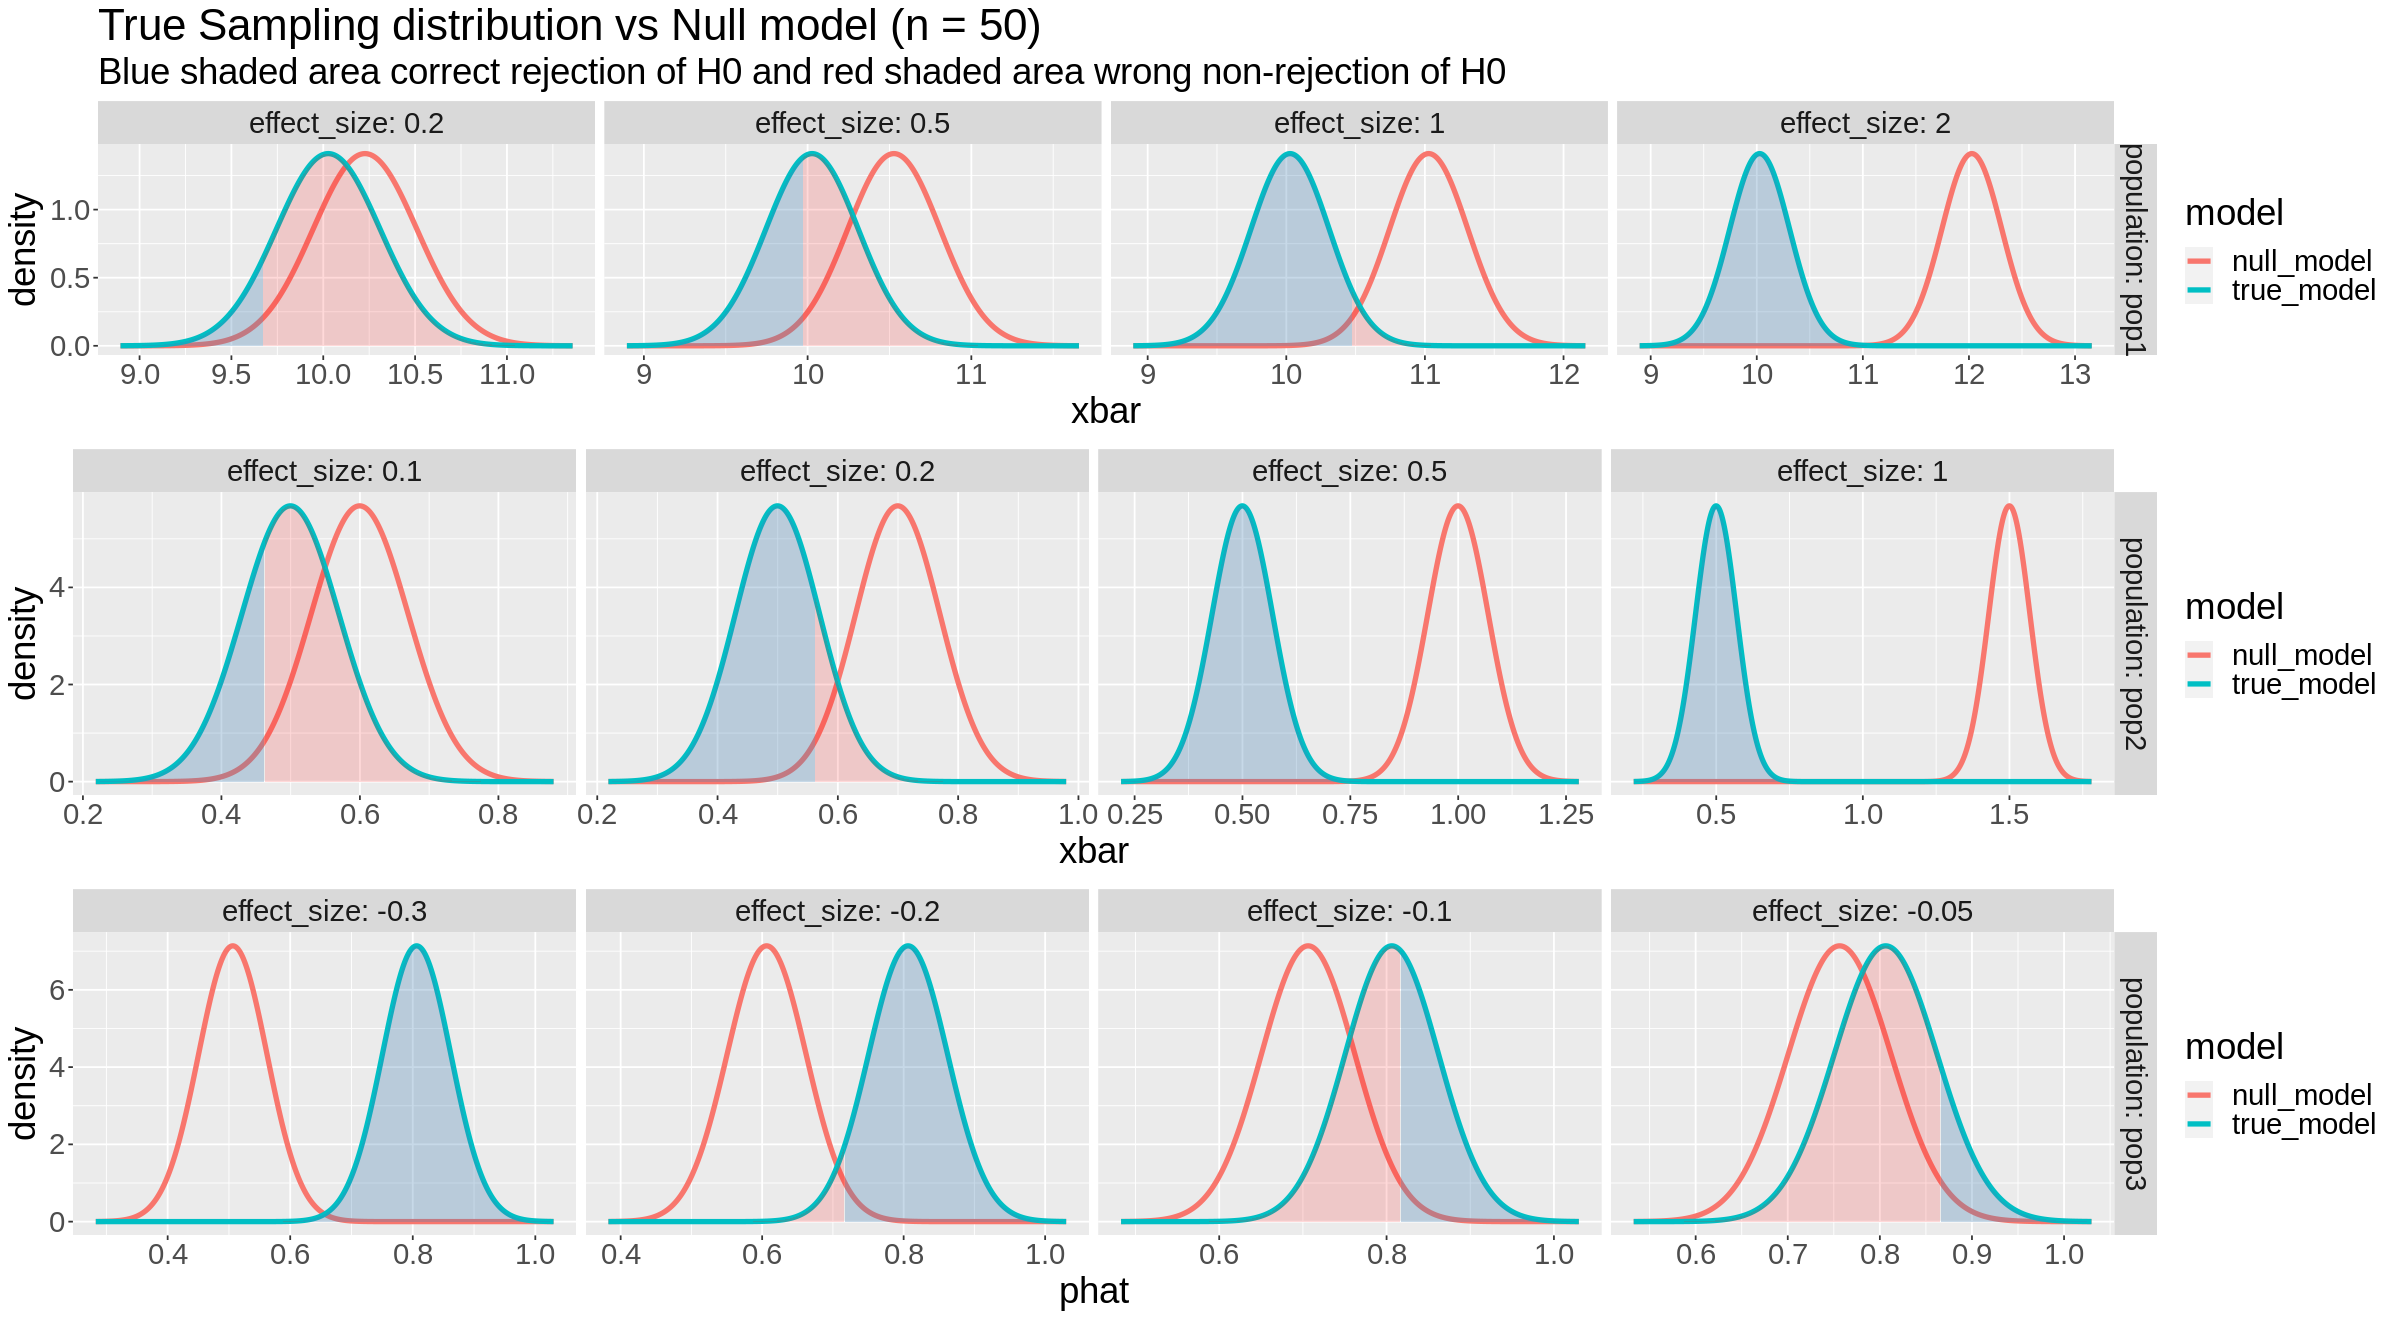

In [25]:
options(repr.plot.width = 20, repr.plot.height = 11)

areas_effect_size <- answer2.2.1 %>% 
    left_join(pops_params) %>% 
    mutate(dist = list(tibble(
        xbar = seq(min(pop_mean, mu0) - 4 * pop_sd/sqrt(n), max(pop_mean, mu0) + 4 * pop_sd/sqrt(n), 0.001),
        true_model = dnorm(xbar, pop_mean, pop_sd/sqrt(n)),
        null_model = dnorm(xbar, mu0, pop_sd/sqrt(n))) %>% 
                      pivot_longer(c(true_model, null_model), names_to = "model", values_to = "density"))) 
plots <- list()
plots <- pops_params$population %>% 
    map(~areas_effect_size %>% 
            unnest(dist) %>% 
            filter(population == .x) %>% 
            ggplot() + 
            geom_line(aes(xbar, density, color = model), lwd = 1.5) + 
            theme(text = element_text(size = 22)) +
            facet_grid(population~effect_size, scales = "free", labeller = label_both)+
            geom_ribbon(data = . %>% filter(model == "true_model", if_else(mu0 > pop_mean, xbar <= qnorm(0.025, mu0, pop_sd/sqrt(n)), xbar >= qnorm(0.975, mu0, pop_sd/sqrt(n)))),
                        aes(x = xbar, ymin = 0, ymax = density), fill = 'steelblue', alpha=.3) +
geom_ribbon(data = . %>% filter(model == "true_model", if_else(mu0 > pop_mean, xbar > qnorm(0.025, mu0, pop_sd/sqrt(n)), xbar < qnorm(0.975, mu0, pop_sd/sqrt(n)))),
                        aes(x = xbar, ymin = 0, ymax = density), fill = 'red', alpha=.15))

plots[[1]] <- plots[[1]] + ggtitle("True Sampling distribution vs Null model (n = 50)",
                                  subtitle = "Blue shaded area correct rejection of H0 and red shaded area wrong non-rejection of H0")
plots[[3]] <- plots[[3]] + xlab("phat")

grid.arrange(grobs = plots)

### 2.2.2 Sample Size

Now, let's focus on the effect of sample size on the probability of Type II Error. For now, consider Population 1 and `effect_size = 0.5` (first row and second column of the plot above). What do you think would happen to both, blue and red curves, if we increase the sample size? Think about this for a second.

**Question 2.2.3**
<br>{points: 1}

Increasing the sample size while keeping everything else the same will result in

A. an increase in the effect size.

B. a decrease in the effect size.

C. a lower overlap between the sampling distribution and the null model if $H_0$ is true.

D. a higher overlap between the sampling distribution and the null model if $H_0$ is true.

E. a higher overlap between the sampling distribution and the null model if $H_0$ is false.

F. a lower overlap between the sampling distribution and the null model if $H_0$ is false.

_Assign your answer to an object called `answer2.2.3`. Your answer should be a single character surrounded by quotes._

In [26]:
# answer2.2.3 <- ...

### BEGIN SOLUTION
answer2.2.3 <- "F"
### END SOLUTION

In [27]:
test_2.2.3()

[1] "Success!"


The cell below plots the sampling distribution of $\bar{X}$ and the null model, for each population, and a fixed effect size, across different sample sizes, and shows the region of correct rejection of $H_0$ and wrong non-rejection of $H_0$. 

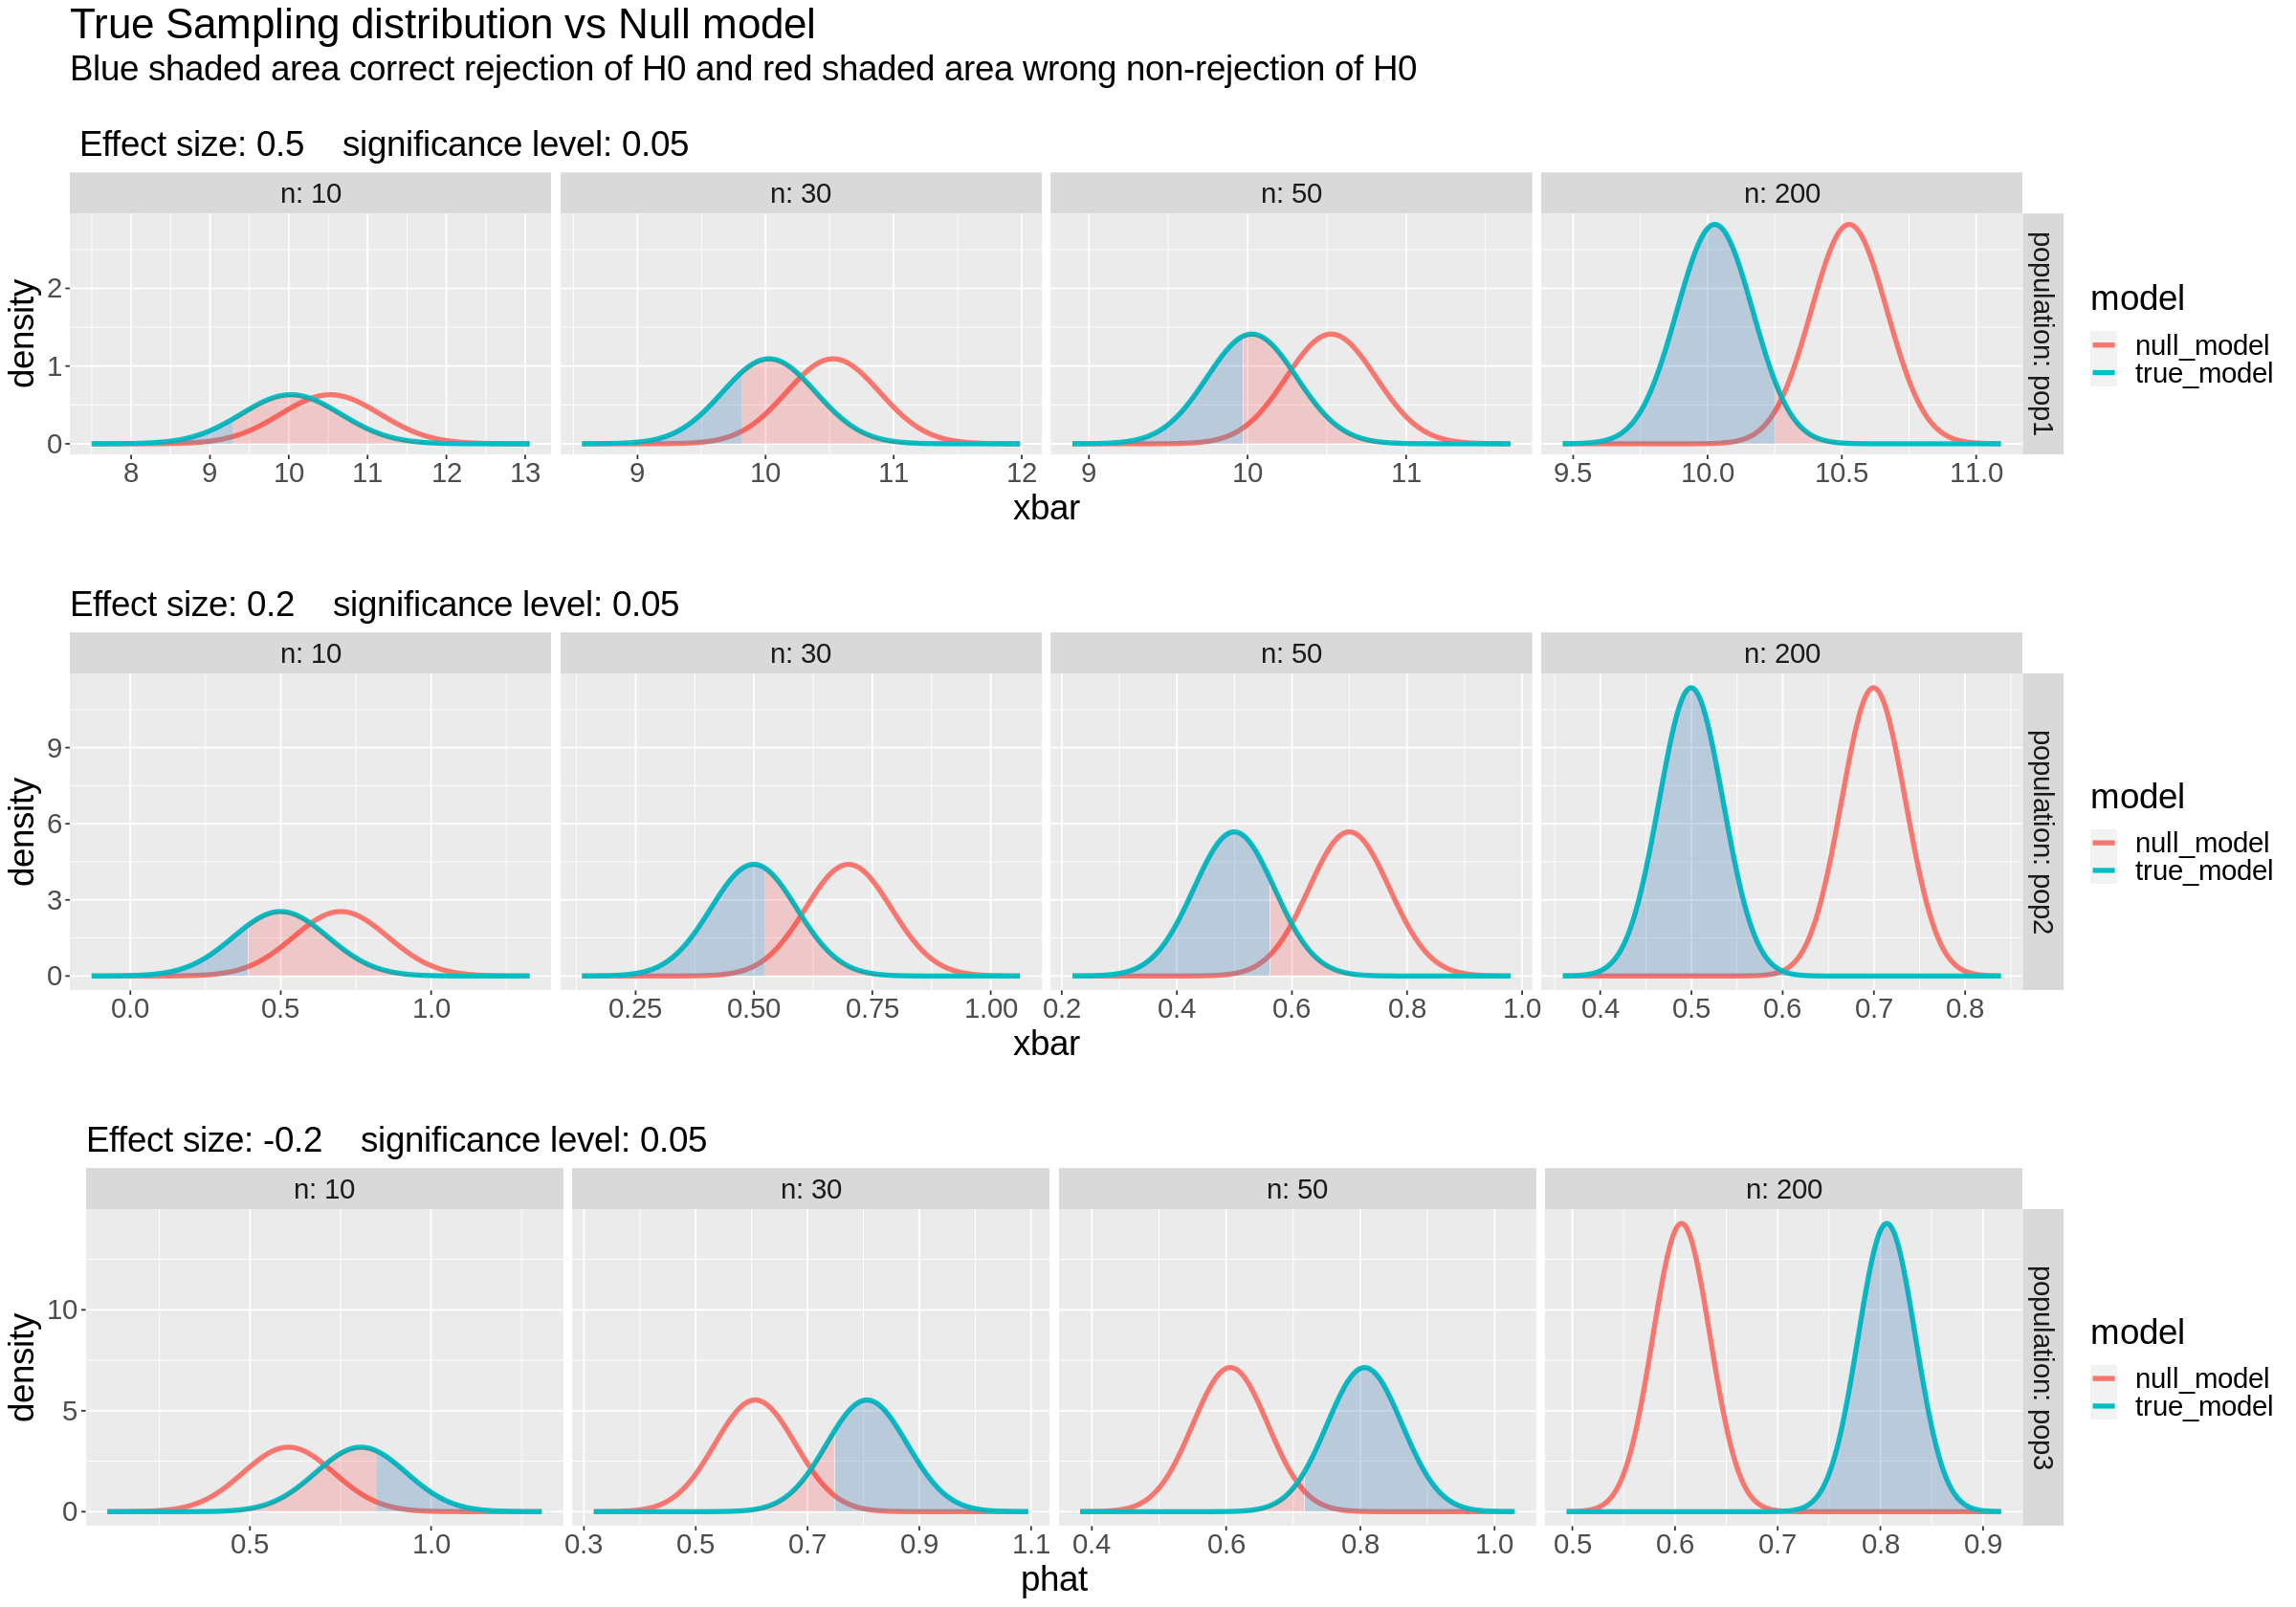

In [28]:
options(repr.plot.width = 20, repr.plot.height = 14)

sample_size_area <- 
    section2.2 %>% 
    select(population, pop_mean, pop_sd, mu0, effect_size) %>% 
    unique() %>%
    filter(population != "pop1" | effect_size == 0.5) %>% 
    filter(population != "pop2" | effect_size == 0.2) %>% 
    filter(population != "pop3" | effect_size == -0.2)  %>% 
    crossing(tibble(n = c(10, 30, 50, 200)))%>% 
    rowwise() %>% 
    mutate(dist = list(tibble(
        xbar = seq(min(pop_mean, mu0) - 4 * pop_sd/sqrt(n), max(pop_mean, mu0) + 4 * pop_sd/sqrt(n), 0.001),
        true_model = dnorm(xbar, pop_mean, pop_sd/sqrt(n)),
        null_model = dnorm(xbar, mu0, pop_sd/sqrt(n))) %>% 
                      pivot_longer(c(true_model, null_model), names_to = "model", values_to = "density"))) 

plots <- list()
plots <- pops_params$population %>% 
    map(~sample_size_area %>% 
            unnest(dist) %>% 
            filter(population == .x) %>% 
            ggplot() + 
            geom_line(aes(xbar, density, color = model), lwd = 1.5) + 
            theme(text = element_text(size = 22)) +
            facet_grid(population~n, scales = "free", labeller = label_both)+
            geom_ribbon(data = . %>% filter(model == "true_model", if_else(mu0 > pop_mean, xbar <= qnorm(0.025, mu0, pop_sd/sqrt(n)), xbar >= qnorm(0.975, mu0, pop_sd/sqrt(n)))),
                        aes(x = xbar, ymin = 0, ymax = density), fill = 'steelblue', alpha=.3) +
geom_ribbon(data = . %>% filter(model == "true_model", if_else(mu0 > pop_mean, xbar > qnorm(0.025, mu0, pop_sd/sqrt(n)), xbar < qnorm(0.975, mu0, pop_sd/sqrt(n)))),
                        aes(x = xbar, ymin = 0, ymax = density), fill = 'red', alpha=.15))

plots[[1]] <- plots[[1]] + ggtitle("True Sampling distribution vs Null model",
                                  subtitle = "Blue shaded area correct rejection of H0 and red shaded area wrong non-rejection of H0\n\n Effect size: 0.5    significance level: 0.05")
plots[[2]] <- plots[[2]] + ggtitle("", subtitle = "Effect size: 0.2    significance level: 0.05")
plots[[3]] <- plots[[3]] + xlab("phat") + ggtitle("", subtitle = "Effect size: -0.2    significance level: 0.05")

grid.arrange(grobs = plots)

### 2.2.3 Significance level



**Question 2.2.4**
<br>{points: 1}

What would happen in the plot above if we changed the significance level while keeping everything else the same?

A. the effect size will change;

B. the overlap between the sampling distribution and the null model will either increase or decrease;

C. the location of the border separating the red shaded region and the blue shaded region will change. 

_Assign your answer to an object called `answer2.2.4`. Your answer should be a single character surrounded by quotes._

In [29]:
# answer2.2.4 <- ...

### BEGIN SOLUTION
answer2.2.4 <- "C"
### END SOLUTION

In [30]:
test_2.2.4()

[1] "Success!"


The cell below plots the sampling distribution of $\bar{X}$ and the null model, for each population, a fixed effect size and sample size, across different significance level $\alpha$, and shows the region of correct rejection of $H_0$ and wrong non-rejection of $H_0$. 

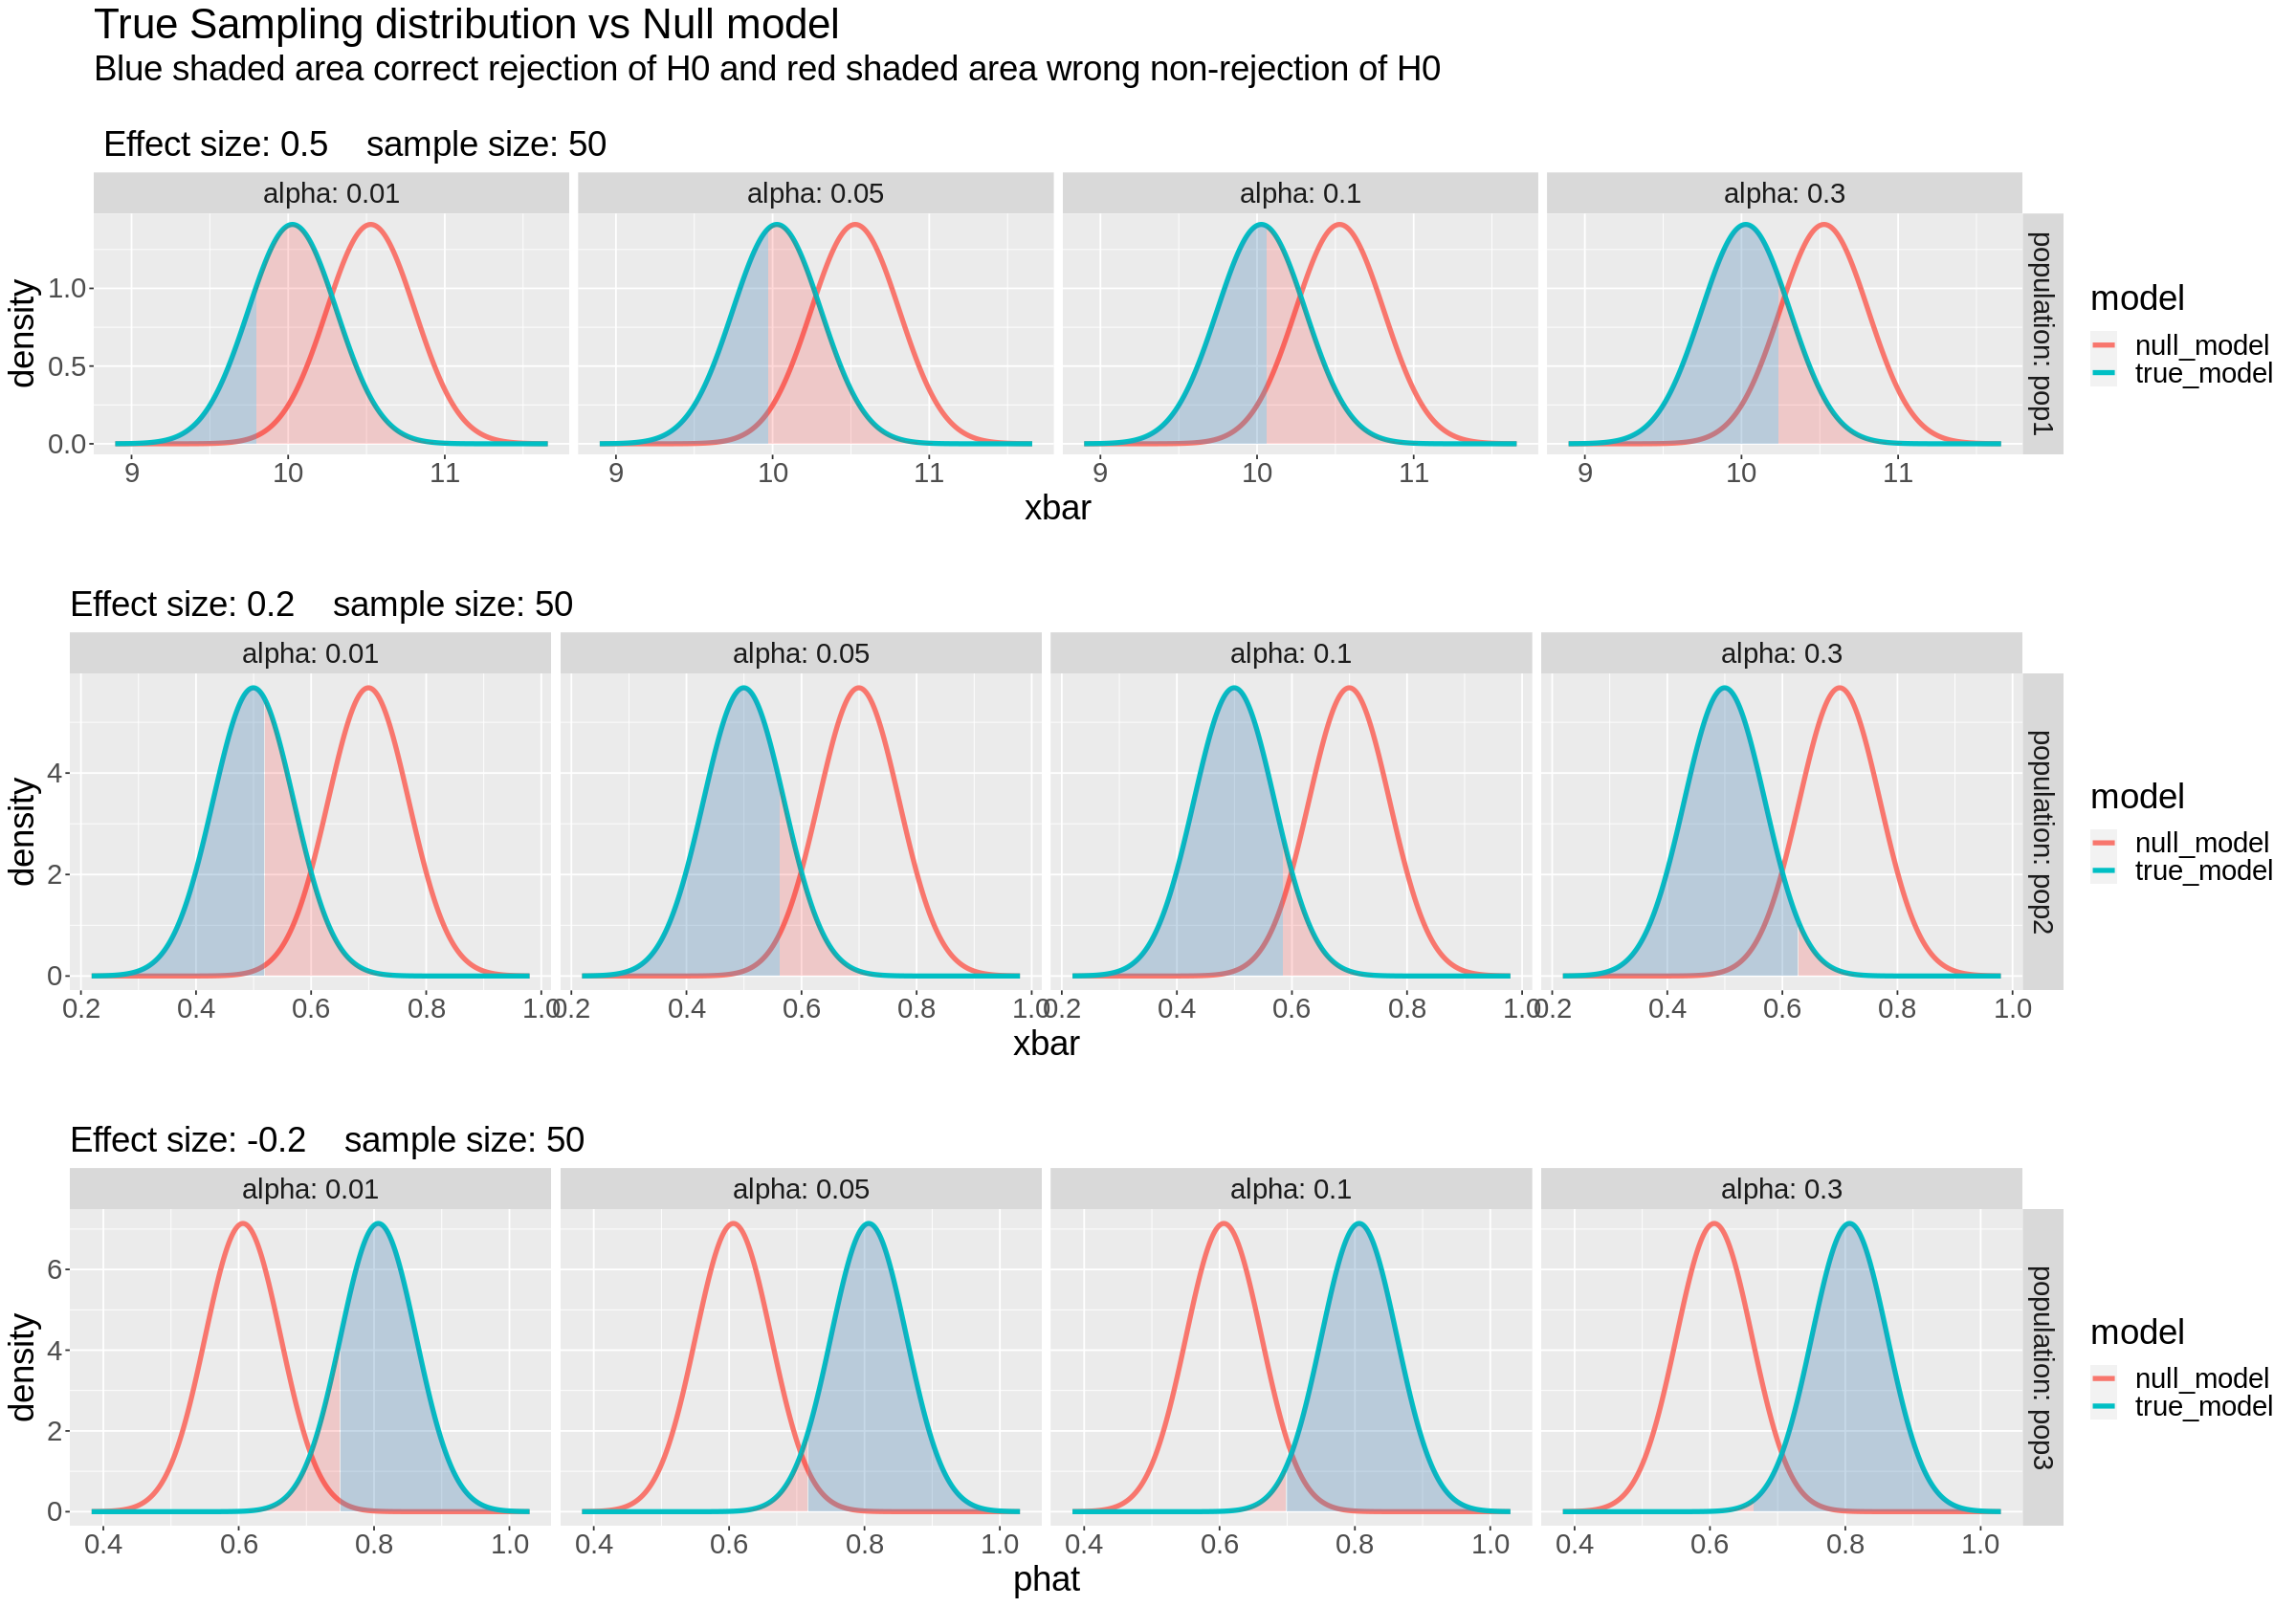

In [31]:
alpha_area <- 
    section2.2 %>% 
    select(population, pop_mean, pop_sd, mu0, effect_size) %>% 
    unique() %>%
    filter(population != "pop1" | effect_size == 0.5) %>% 
    filter(population != "pop2" | effect_size == 0.2) %>% 
    filter(population != "pop3" | effect_size == -0.2)  %>% 
    crossing(tibble(alpha = c(0.01, 0.05, 0.1, 0.3)))%>% 
    rowwise() %>% 
    mutate(dist = list(tibble(
        xbar = seq(min(pop_mean, mu0) - 4 * pop_sd/sqrt(n), max(pop_mean, mu0) + 4 * pop_sd/sqrt(n), 0.001),
        true_model = dnorm(xbar, pop_mean, pop_sd/sqrt(n)),
        null_model = dnorm(xbar, mu0, pop_sd/sqrt(n))) %>% 
                      pivot_longer(c(true_model, null_model), names_to = "model", values_to = "density"))) 

plots <- list()
plots <- pops_params$population %>% 
    map(~alpha_area %>% 
            unnest(dist) %>% 
            filter(population == .x) %>% 
            ggplot() + 
            geom_line(aes(xbar, density, color = model), lwd = 1.5) + 
            theme(text = element_text(size = 22)) +
            facet_grid(population~alpha, scales = "free", labeller = label_both)+
            geom_ribbon(data = . %>% filter(model == "true_model", if_else(mu0 > pop_mean, xbar <= qnorm(alpha/2, mu0, pop_sd/sqrt(n)), xbar >= qnorm(1-alpha/2, mu0, pop_sd/sqrt(n)))),
                        aes(x = xbar, ymin = 0, ymax = density), fill = 'steelblue', alpha=.3) +
geom_ribbon(data = . %>% filter(model == "true_model", if_else(mu0 > pop_mean, xbar > qnorm(alpha/2, mu0, pop_sd/sqrt(n)), xbar < qnorm(1-alpha/2, mu0, pop_sd/sqrt(n)))),
                        aes(x = xbar, ymin = 0, ymax = density), fill = 'red', alpha=.15))

plots[[1]] <- plots[[1]] + ggtitle("True Sampling distribution vs Null model",
                                  subtitle = "Blue shaded area correct rejection of H0 and red shaded area wrong non-rejection of H0\n\n Effect size: 0.5    sample size: 50")
plots[[2]] <- plots[[2]] + ggtitle("", subtitle = "Effect size: 0.2    sample size: 50")
plots[[3]] <- plots[[3]] + xlab("phat") + ggtitle("", subtitle = "Effect size: -0.2    sample size: 50")

grid.arrange(grobs = plots)

**Question 2.2.5**
<br>{points: 1}

Select all true statements.

A. If you increase the sample size, you reduce the probability of Type I Error.

B. If you increase the sample size, you reduce the probability of Type II Error.

C. A reduction of the significance level reduces the chance of Type I Error.

D. A reduction of the significance level increases the chance of Type I Error.

E. A reduction of the significance level reduces the chance of Type II Error.

F. A reduction of the significance level increases the chance of Type II Error.

_Assign your answer to an object called `answer2.2.5`. Your answer should be a single character surrounded by quotes._

In [32]:
# answer2.2.5 <- ...

### BEGIN SOLUTION
answer2.2.5 <- "BCF"
### END SOLUTION

In [33]:
test_2.2.5()

[1] "Success!"


### 2.3 Power of the test

The power of the test is the probability of rejecting $H_0$ when $H_0$ is false. It is represented by the blue area in the plots above. The red area, on the other hand, is the probability of Type II Error. Therefore, the power of the test is 1 - P("Type II Error").

So far in the course we have been defining $H_1: \mu > \mu_0$, $H_1: \mu < \mu_0$, or $H_1: \mu \neq \mu_0$. So, there is an infinite number of possible values for $\mu$ in the alternative hypothesis. The problem is that the probability of Type II Error depends on the value of the parameter $\mu$.

**Question 2.2.6** 
<br> {points: 1}

Consider our population 1. Suppose we want to test $H_0: \mu_1 = 10.2271932$ vs $H_1: \mu_1 \neq 10.2271932$. What is the probability of Type II Error knowing that $\mu_1 = 10.0271932$? From your `answer2.2.1` obtain the proportion of rejections.

--------------------------
```r
answer2.2.6 <- 
    answer2.2.1 %>% 
    filter(... & ...) %>% 
    pull(...)
``` 

_Assign your answer to an object called `answer2.2.6`. Your answer should be a single number._

In [34]:
# answer2.2.6 <- ...

### BEGIN SOLUTION
answer2.2.6 <- 
    answer2.2.1 %>% 
    filter(effect_size == 0.2 & population == "pop1") %>% 
    pull(proportion_rejection)
### END SOLUTION

answer2.2.6

[1] 0.1196

In [35]:
test_2.2.6()

[1] "Success!"


**Question 2.2.7** 
<br> {points: 1}

Consider our population 1. Suppose we want to test $H_0: \mu_1 = 10.5$ vs $H_1: \mu_1 \neq 10.5$. Now, if you did not know the true mean to be $\mu_1 = 10.0271932$, what is the probability of Type II Error? 

In this case, we would need to look at each possible $\mu$ in $H_1$, and the test would have a different Type II Error for each $\mu$. Therefore, we would be talking about a power function (as a function of what the true mean $\mu$ is), as opposed to just the test's power. 

Let us investigate how this works. We want to see the probability of rejecting $H_0$ for several of the possible values of $\mu$ in $H_1$. To be able to estimate these proportions, let's modify the population mean by adding a constant to all elements of the population. Here is what we are going to do:

1. Let's change our population mean by adding a constant to all values in `pop1`. We will modify the mean to be $9.0, 9.1, 9.2, 9.3, ..., 13$. These will be store in the column `possible_mu`. (We want to do this to check how often the test will reject $H_0$ if the mean were these values.)

2. For each one of the populations with new means, we are going to take 2000 samples of size 50, then calculate the sample mean for each sample. 

The cell below performs Steps 1 and 2. 

3. Next, you need to calculate the p-value of the test. Remember, the null model is:
    $$
    \bar{X} \sim N\left(\mu_0, \sigma\left/\sqrt{n}\right.\right)
    $$



_Assign your answer to an object called `power_function_2.2.7`. Your answer should be a single number._

In [36]:
## Run this cell before continuing

set.seed(20210322) # Do not chance this

pop1 <- pops %>%    # Select population 1
    filter(population == "pop1") %>% 
    select(variable) 

possible_mu <- # Creates an array with some possible values for the unknown population mean.
    seq(9.0, 13, 0.1) 

multiple_pop <-     
    tibble(possible_mu) %>% 
    mutate(new_pop = list(pop1)) %>% # Creates one population for each value of mu
    mutate(new_pop = map2(possible_mu, new_pop, # making the mean of the population to be mu
                          ~ .y %>% 
                            mutate(new_variable = variable + .x - mean(pop1$variable)))
                     ) %>% 
    mutate(samples = map(new_pop, ~ 
                         .x %>% 
                         rep_sample_n(reps = 2000, size = 50) %>%  # Takes a sample for each population
                         group_by(replicate) %>% # Calculates the mean for each sample
                         summarise(sample_mean = mean(new_variable), `.groups` = "drop"))) %>%  
    select(-new_pop) %>% # Discard the modified populations
    unnest(samples) %>% 
    mutate(pop_sigma = pops_params$pop_sd[1]) # Add the population standard deviation to the data frame

head(multiple_pop)

possible_mu,replicate,sample_mean,pop_sigma
<dbl>,<int>,<dbl>,<dbl>
9,1,9.086281,1.999156
9,2,9.020593,1.999156
9,3,9.778984,1.999156
9,4,9.450037,1.999156
9,5,9.064995,1.999156
9,6,8.729254,1.999156


In [37]:
mu0 <- 10.5
n <- 50

### BEGIN SOLUTION

power_function_2.2.7 <- 
    multiple_pop %>% 
    mutate(p_value = 2 * pnorm(abs(sqrt(n) * (sample_mean - mu0)/pop_sigma), lower.tail = FALSE)) %>% 
    group_by(possible_mu) %>% 
    summarise(prop_rejection = mean(p_value < 0.05))

### END SOLUTION

power_function_2.2.7

`summarise()` ungrouping output (override with `.groups` argument)



possible_mu,prop_rejection
<dbl>,<dbl>
9.0,0.9995
9.1,0.9970
9.2,0.9970
9.3,0.9910
9.4,0.9765
9.5,0.9490
9.6,0.8975
9.7,0.8060
9.8,0.6775


In [38]:
test_2.2.7()

[1] "Success!"


**Question 2.2.8**
<br> {points: 1}

Since the power of the test depends on $\mu$, let's plot the power function you obtained in the previous question using `geom_line`. Fill in the scaffolding below:

```r
power_function_plot_2.2.8 <- 
    power_function_2.2.7 %>% 
    ggplot() +
    geom_line(aes(..., ...)) + 
    theme(text = element_text(size = 22)) + 
    xlab(expression(mu)) + 
    ylab(expression(paste("Probability of rejecting ", H[0]))) + 
    ggtitle("Power function", subtitle = expression(paste(H[0], ": ", mu==10.5, " vs ", H[1], ": ", mu!=10.5))) +
    geom_vline(xintercept = mu0, color = "red")
```

_Assign your plot to an object called `power_function_plot_2.2.8`._

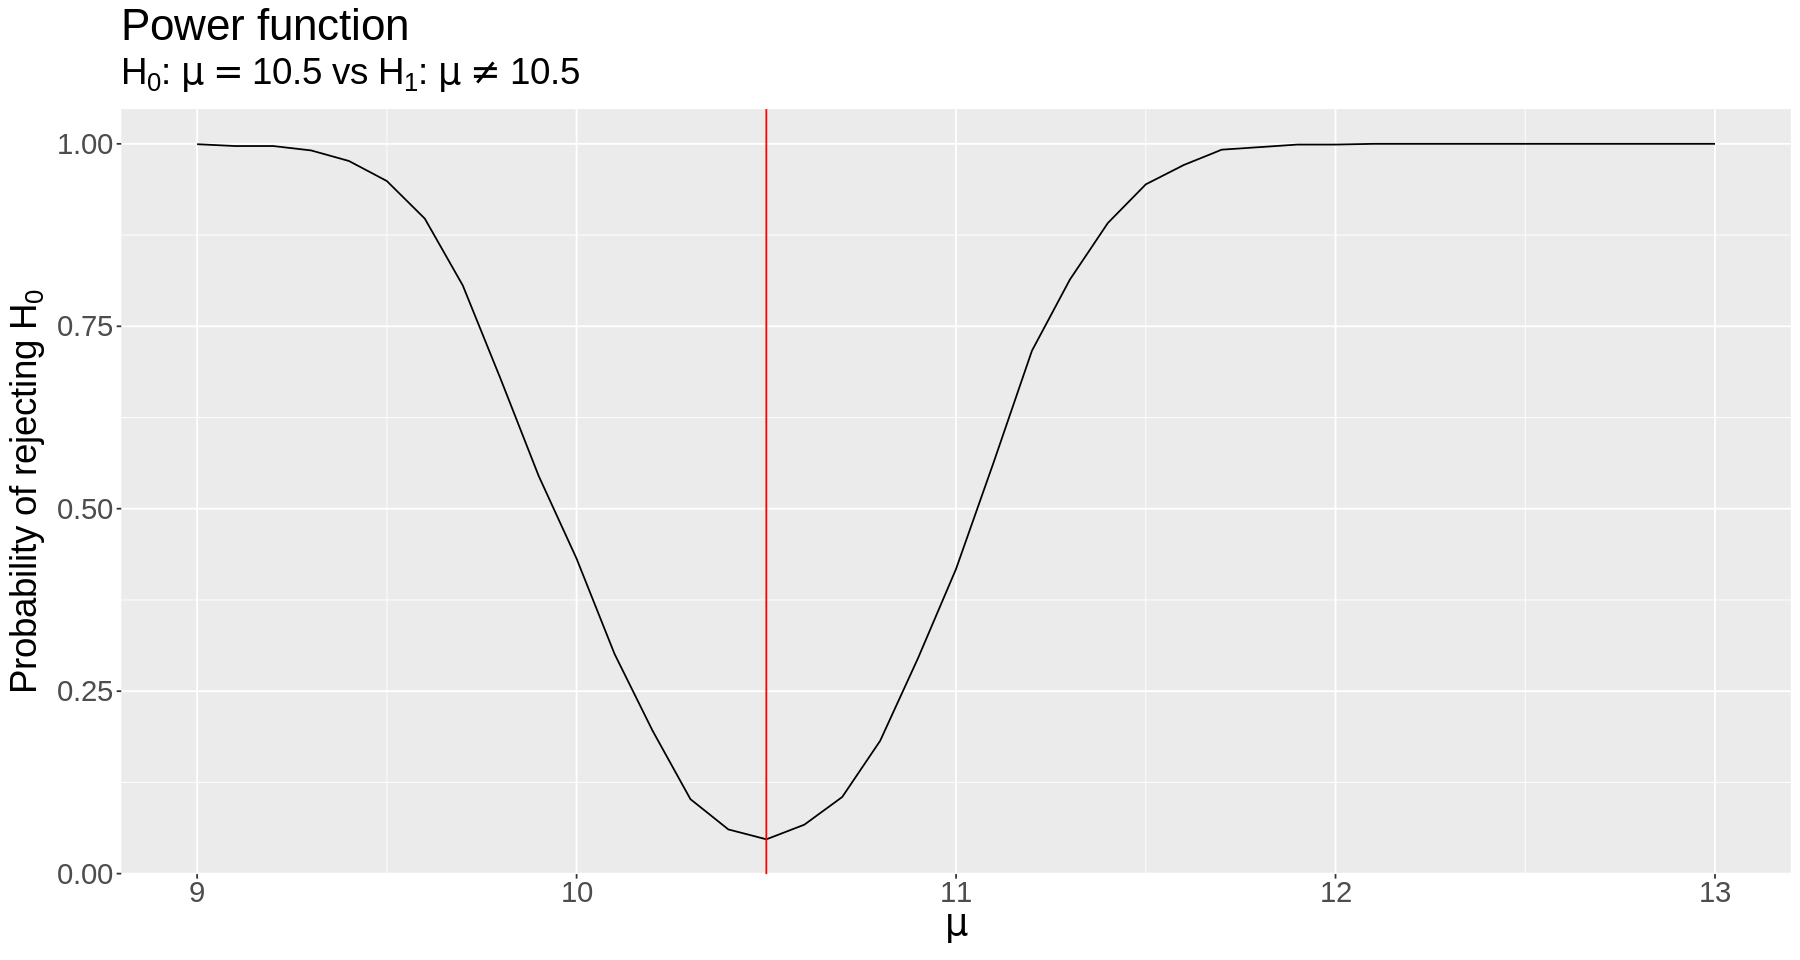

In [39]:
options(repr.plot.width = 15, repr.plot.height = 8)

### BEGIN SOLUTION
power_function_plot_2.2.8 <- 
    power_function_2.2.7 %>% 
    ggplot() +
    geom_line(aes(possible_mu, prop_rejection)) + 
    theme(text = element_text(size = 22)) + 
    xlab(expression(mu)) + 
    ylab(expression(paste("Probability of rejecting ", H[0]))) + 
    ggtitle("Power function", subtitle = expression(paste(H[0], ": ", mu==10.5, " vs ", H[1], ": ", mu!=10.5))) +
    geom_vline(xintercept = mu0, color = "red")
### END SOLUTION

power_function_plot_2.2.8

In [40]:
test_2.2.8()

[1] "Success!"


## 3. Revisiting Confidence intervals

### 3.1 The link between confidence intervals and two-tail hypothesis tests

A $100(1-\alpha)\%$ confidence interval for the mean, $\mu$, or proportion, $p$, contains "plausible" values for the respective parameter for the sample we have, with a confidence level $100(1-\alpha)\%$. 

On the other hand, if we were to test hypotheses of the type $H_0: \mu=\mu_0$ vs $H_1: \mu\neq \mu_0$ (or $H_0: p = p_0$ vs $H_1: p \neq p_0$)  with significance level $\alpha$, we want reject $H_0$ if we have strong evidence that $\mu_0$ is not a "plausible" value for the parameter. 

In fact, it is possible to show that we would reject $H_0$ at $\alpha$ significance level, if and only if $\mu_0$ does not belong to the $100(1-\alpha)\%$ confidence interval. 

Try going over your Worksheet/Tutorial 8 and checking the confidence intervals outputted with the hypothesis tests you did there, and observe that every time you rejected the null hypothesis, the hypothesized value of the parameter didn't belong to the corresponding confidence interval.

###  3.2 Improving the coverage of confidence interval for the mean 

In Week 7, we discussed how to obtain a confidence interval for the mean based on the central limit theorem or the assumption of Gaussian population. Let's refresh our memory. We learned that as a consequence of the CLT we have that:

$$
\bar{X}\sim N\left(\mu, \sigma\left/\sqrt{n}\right.\right)
$$

Therefore, 
$$
\frac{\bar{X}-\mu}{\sigma\left/\sqrt{n}\right.}\sim N\left(0, 1\right)
$$

We used this result to obtain the $100(1-\alpha)\%$ confidence interval for the mean, given by:
$$
 \bar{X}\pm z^*_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}
$$

Unfortunately, the formula above has limited applicability since $\sigma$ is rarely known. When $\sigma$ is unknown, we replace $\sigma$ with its estimator, $s$ (the sample standard deviation). However, although for large values of $n$ the interval above is still valid, we can do better. In fact, we learned in Week 8 that the extra uncertainty brought by replacing $\sigma$ with its estimator $s$ changed the distribution underlying distribution:

$$
\frac{\bar{X}-\mu}{s\left/\sqrt{n}\right.}\sim t_{n-1}
$$

We should then adapt our confidence interval accordingly. A more accurate confidence interval is:

$$
 \bar{X}\pm t^*_{n-1, 1-\alpha/2}\frac{s}{\sqrt{n}}
$$
where $t^*_{n-1, 1-\alpha/2}$ is the $(1-\alpha/2)$-quantile of $t$-distribution with $n-1$ degrees of freedom 

**Question 3.1** 
<br> {points: 1}

In Question 3.4 of Worksheet 7, you calculated the 99% confidence interval for the mean of `body_mass_g` of the `Chinstrap` specie using the interval $\bar{X}\pm z^*_{1-\alpha/2}\frac{\sigma}{\sqrt{n}}$, which resulted in $[3718.53; 3747.647]$. This time, use the $t$-distribution to obtain the 99% confidence interval for the mean of `body_mass_g` of the `Chinstrap` species.
 
_Assign your data frame to an object called `mean_body_mass_chinstrap_ci`. The data frame should contain two columns only: `lower_ci` and `upper_ci`._

In [41]:
### BEGIN SOLUTION
estimates <- 
    penguins %>% 
    filter(species == 'Chinstrap' & !is.na(body_mass_g)) %>% 
    summarise(sample_average = mean(body_mass_g),
              n = n(),
              sample_std_error = sd(body_mass_g)/sqrt(n))

mean_body_mass_chinstrap_ci <- tibble(
    lower_ci = estimates$sample_average + qt(0.005, estimates$n-1) * estimates$sample_std_error,
    upper_ci = estimates$sample_average + qt(0.995, estimates$n-1) * estimates$sample_std_error,
)
### END SOLUTION

head(mean_body_mass_chinstrap_ci)

lower_ci,upper_ci
<dbl>,<dbl>
3609.522,3856.655


In [42]:
test_3.1()

[1] "Success!"


As you can see, the results you obtained using the $t$-distribution are similar to those obtained using the normal distribution. This happened because $n$ is relatively large. If you were dealing with a smaller $n$, say $n = 20$, the difference would be more relevant.

## 4. Inference on Multiple Parameters

So far, we have been discussing inference for one parameter in an isolated form. However, in many cases, you might be interested in more than one parameter. For example:

1. you could be interested in two different variables, say `height` and `weight`, and want to learn about the mean height and mean weight; 
2. you could be interested in comparing the mean across different groups. What is the average total mileage until the first defect for Toyota, Honda, Ford, and General Motors cars?

Could we just do multiple single-parameter analyses that we have learned so far? Like calculating multiple individual confidence intervals? or conduct multiple hypothesis tests? 

In this section, we are going to investigate what happens in these situations. 

### 4.1 Multiple confidence interval

Suppose we have a population of cars, and we are interested in the following variables:

1. `km_per_litre`: how many km the car drives per litre of fuel;
2. `mileage_till_first_defect`: how many km the car drove until the first defect happened;
3. `horse_power`: the engine power of the car.
4. `price`: the price of the car, as new;
5. `brand`: the brand of the car;

Let's take a sample of 100 cars.

In [43]:
# Run this cell before continuing

set.seed(20210322) # Do not change this
true_mean = c(10, 5000, 300, 35000)

cars <- as.data.frame(matrix(rnorm(400, true_mean, c(1, 500, 70, 5000)), ncol = 4, byrow=TRUE , dimnames = list(c(), c("km_per_litre", "mileage_till_first_defect", "horse_power", "price"))))
cars <- 
    cars %>% 
    mutate(brand = as.factor(sample(rep(x = c("Toyota", "Honda", "Ford", "GM"), times = 25), 100)))

head(cars)

,km_per_litre,mileage_till_first_defect,horse_power,price,brand
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,8.509292,4933.470,315.3914,34439.47,Honda
2,9.583146,4590.013,313.8220,38646.43,Honda
3,9.188287,5687.130,311.2729,35528.10,Ford
4,9.423048,4597.573,174.0756,33863.56,GM
5,10.033290,4933.503,361.5400,29557.25,Honda
6,10.959621,5361.293,256.1897,38302.56,GM


**Question 4.1** 
<br> {points: 1}

Using the sample stored in `cars`, obtain an interval estimate, using 90% confidence level, for the mean of each of the variables: `km_per_litre`, `mileage_till_first_defect`, `horse_power`, and `price`. 

--------------------------

```r
ci_4.1 <- 
    cars %>% 
    select(-brand) %>% 
    summarise_all(list(mean = ..., sd = ...)) %>% 
    pivot_longer(everything(), 
                 names_to = c("variable", 'statistic'), 
                 names_pattern = "(.+)_([a-z]+)", 
                 values_to = "value") %>% 
    pivot_wider(names_from = statistic) %>% 
    mutate(lower_ci = ...,
           upper_ci = ...)
```


_Assign your data frame to an object called `ci_4.1`. The `ci_4.1` data frame should have 5 columns: `variable`, `mean`, `sd`, `lower_ci`, and `upper_ci`._

In [44]:
n <- nrow(cars)

### BEGIN SOLUTION
ci_4.1 <- 
    cars %>% 
    select(-brand) %>% 
    summarise_all(list(mean = mean, sd = sd)) %>% 
    pivot_longer(everything(), 
                 names_to = c("variable", 'statistic'), 
                 names_pattern = "(.+)_([a-z]+)", 
                 values_to = "value") %>% 
    pivot_wider(names_from = statistic) %>% 
    mutate(lower_ci = mean - qt(0.95, n-1) * sd/sqrt(n),
           upper_ci = mean + qt(0.95, n-1) * sd/sqrt(n))
### END SOLUTION

ci_4.1

variable,mean,sd,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
km_per_litre,9.993071,0.891409,9.845062,10.14108
mileage_till_first_defect,4972.202870,544.807554,4881.743506,5062.66223
horse_power,292.261166,74.868400,279.830083,304.69225
price,35033.525570,5070.643917,34191.600339,35875.45080


In [45]:
test_4.1()

[1] "Success!"


**Question 4.2** 
<br> {points: 1}

Since the `cars` dataset was simulated, we know the true value of the parameters. For each variable, check if the confidence interval you calculated in the previous question contains the parameters' true values. Add two columns, `true_mean` and `captured`, to the data frame which should be `TRUE` or `FALSE`.

variable | true mean 
---------|---------
`km_per_litre` | 10
`mileage_till_first_defect`| 5000
`horse_power` | 300
`price` | 35000


---------------------------------

```r
ci_4.1 <- 
    ci_4.1 %>% 
    mutate(true_mean = true_mean,
           captured = ...)
```

In [46]:

### BEGIN SOLUTION
ci_4.1 <- 
    ci_4.1 %>% 
    mutate(true_mean = true_mean,
           captured = true_mean <= upper_ci & true_mean >= lower_ci) 
### END SOLUTION

ci_4.1

variable,mean,sd,lower_ci,upper_ci,true_mean,captured
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
km_per_litre,9.993071,0.891409,9.845062,10.14108,10,TRUE
mileage_till_first_defect,4972.202870,544.807554,4881.743506,5062.66223,5000,TRUE
horse_power,292.261166,74.868400,279.830083,304.69225,300,TRUE
price,35033.525570,5070.643917,34191.600339,35875.45080,35000,TRUE


In [47]:
test_4.2()

[1] "Success!"


**Question 4.3** 
<br> {points: 1}

Individually, we expect that 90% of our confidence intervals will capture the true mean of each given variable. However, how are these intervals doing collectively? In other words, what is the probability of taking a sample that will result in all four intervals containing the true mean? Let's check it out. In the cell below, we take 1000 samples of size 100 cars and stored them in an object called `multiple_cars`. Your job is:

1. For each sample, calculate the mean and standard deviation of each of the variables;
2. Calculate the 90% confidence interval for the mean in each sample;
3. Create a `captured` column that flags if the true mean of each variable was captured;
4. For each sample, check if the confidence intervals for all four parameters captured the true value of the parameter.
5. Calculate the proportion of samples that provides confidence intervals that captured all four true mean of each variable.

--------------------------------------------

```r
prob_collectively_capturing <- 
    multiple_cars %>%
    select(-brand) %>%
    group_by(...) %>% 
    summarise_all(list(mean = ..., sd = ...)) %>% 
    pivot_longer(ends_with(c("_mean", "_sd")), 
                 names_to = c("variable", 'statistic'), 
                 names_pattern = "(.+)_([a-z]+)", 
                 values_to = "value") %>% 
    pivot_wider(names_from = statistic) %>% 
    mutate(lower_ci = ...,
           upper_ci = ...) %>% 
    left_join(tibble(
                true_mean = true_mean, 
                variable = c("km_per_liter", "mileage_till_first_defect", "horse_power", "price")
              )) %>% 
    mutate(captured = ...) %>% 
    group_by(...) %>% 
    summarise(n_param_captured = ...) %>% 
    summarise(prob = ...)
```


_Assign your data frame to an object called `prob_collectively_capturing`. This data frame should have only one row and one column `prob`._

In [48]:
# Run this cell before continuing....

set.seed(20210321) # Do not change this

multiple_cars <- # Draw 1000 samples of size 100 cars.
    seq(1, 1000) %>% 
    map_df(~as.data.frame(matrix(rnorm(400, true_mean, c(1, 500, 70, 5000)), ncol = 4, byrow=TRUE , dimnames = list(c(), c("km_per_liter", "mileage_till_first_defect", "horse_power", "price")))) %>% 
            mutate(brand = as.factor(sample(rep(x = c("Toyota", "Honda", "Ford", "GM"), times = 25), 100))) %>% 
            mutate(replicate = .x))

head(multiple_cars)

,km_per_liter,mileage_till_first_defect,horse_power,price,brand,replicate
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,9.681528,5117.489,454.3605,34866.44,Honda,1
2,10.870360,5753.396,223.3931,36615.36,Toyota,1
3,10.993903,4745.558,318.8218,37709.18,Ford,1
4,11.667467,4940.094,201.9206,38044.26,Toyota,1
5,10.782566,5396.929,305.3055,44414.85,Ford,1
6,10.626153,4580.264,361.2297,35137.34,Ford,1


In [49]:
### BEGIN SOLUTION

prob_collectively_capturing <- 
    multiple_cars %>% 
    select(-brand) %>% 
    group_by(replicate) %>% 
    summarise_all(list(mean = mean, sd = sd)) %>% 
    pivot_longer(ends_with(c("_mean", "_sd")), 
                 names_to = c("variable", 'statistic'), 
                 names_pattern = "(.+)_([a-z]+)", 
                 values_to = "value") %>% 
    pivot_wider(names_from = statistic) %>% 
    mutate(lower_ci = mean - qt(0.95, n-1) * sd/sqrt(n),
           upper_ci = mean + qt(0.95, n-1) * sd/sqrt(n)) %>% 
    left_join(tibble(
                true_mean = true_mean, 
                variable = c("km_per_liter", "mileage_till_first_defect", "horse_power", "price")
              )) %>% 
    mutate(captured = true_mean <= upper_ci & true_mean >= lower_ci) %>% 
    group_by(replicate) %>% 
    summarise(n_param_captured = sum(captured)) %>% 
    summarise(prob = mean(n_param_captured == 4))

### END SOLUTION


prob_collectively_capturing

Joining, by = "variable"

`summarise()` ungrouping output (override with `.groups` argument)



prob
<dbl>
0.66


In [50]:
test_4.3()

[1] "Success!"


As you can see, even though each individual interval has a probability of 90% of capturing the true mean, if we consider the probability that all four intervals simultaneously capture all four parameters, we are dealing with a much lower probability. In fact, we can calculate this mathematically. Since, in this case, the variables are independent, we can use the product rule:

$$
P(\text{All four intervals capture the true mean}) = 0.9^4 = 0.6561
$$

### 4.2 Multiple Hypothesis Tests

Similarly to the confidence intervals, when conducting multiple hypothesis tests, the probability of errors quickly increases.  

Suppose you want to test if there is a difference in reliability between the car brands. To do that, you decided to test if there is a difference in means of `mileage_till_first_defect` between the brands. A possible way to do this, is making pairwise comparison between the brands. Since we have 4 brands, it will be necessary to perform ${4 \choose 2} = 6$ hypothesis tests: 

1. $H_0: \mu_{Toyota} = \mu_{Honda}$ vs $H_1: \mu_{Toyota} \neq \mu_{Honda}$ 
2. $H_0: \mu_{Toyota} = \mu_{GM}$  vs $H_1: \mu_{Toyota} \neq \mu_{GM}$ 
3. $H_0: \mu_{Toyota} = \mu_{Ford}$ vs $H_1: \mu_{Toyota} \neq \mu_{Ford}$ 
4. $H_0: \mu_{Honda} = \mu_{GM}$ vs $H_1: \mu_{Honda} \neq \mu_{GM}$ 
5. $H_0: \mu_{Honda} = \mu_{Ford}$ vs $H_1: \mu_{Honda} \neq \mu_{Ford}$ 
6. $H_0: \mu_{GM} = \mu_{Ford}$ vs $H_1: \mu_{GM} \neq \mu_{Ford}$ 

In our simulated data set, we know that there is no difference. We used the same mean for all the brands. Therefore, to make the right decision that there is no difference in reliability among the brands, we need to not reject $H_0$ in all 6 hypothesis tests.

**Question 4.4**
<br>{points: 1}

If we end up rejecting $H_0$ in one or more of the 6 hypothesis tests, what type of error would we be making?

A. Type I Error.
 
B. Type II Error.

C. Both.

D. None.

E. It depends.

_Assign your answer to an object called `answer4.4`. Your answer should be a single character surrounded by quotes._

In [51]:
# answer4.4 <- ...

### BEGIN SOLUTION
answer4.4 <- "A"
### END SOLUTION

In [52]:
test_4.4()

[1] "Success!"


**Question 4.5** 
<br> {points: 1}

Note that, at this stage, we are trying to answer only one question: "is there a difference in reliability between the four brands?". To answer this single question, we are going to perform 6 hypothesis tests. In this exercise, we are going to measure the probability of reaching the wrong conclusion, that there is a difference in reliability. Here's what we are going to do:

Using the multiple samples stored in the `multiple_cars` object,
1. conduct all six hypothesis tests in each sample. 
2. calculate the proportion of samples for which $H_0$ was rejected in at least one of the six tests.

-------------------------------------
```r
n_groups <- 25

prob_multiple_tests <- 
    multiple_cars %>% 
    select(..., ..., ...) %>% 
    group_by(..., ...) %>% 
    summarise(mean = ..., sd = ...) %>% 
    inner_join(x = ., y = ., by = c("replicate")) %>% 
    filter(brand.x != brand.y) %>% 
    mutate(test_statistic = ...,
           df = (sd.x^2 / n_groups + sd.y^2 / n_groups)^2 / (sd.x^4 / (n_groups^2 * (n_groups - 1)) + sd.y^4 / (n_groups^2 * (n_groups - 1))),
           p_value = ...) %>% 
    mutate(reject = ...) %>% 
    group_by(...) %>% 
    summarise(n_reject = ..., `.groups` = "drop") %>% 
    summarise(prop_error_type_1 = ...)  
```

_Assign your data frame to an object called `prob_multiple_tests`._

In [53]:
n_groups <- 25

### BEGIN SOLUTION

prob_multiple_tests <- 
    multiple_cars %>% 
    select(replicate, brand, mileage_till_first_defect) %>% 
    group_by(replicate, brand) %>% 
    summarise(mean = mean(mileage_till_first_defect), sd = sd(mileage_till_first_defect)) %>% 
    inner_join(x = ., y = ., by = c("replicate")) %>% 
    filter(brand.x != brand.y) %>% 
    mutate(test_statistic = (mean.x - mean.y) / sqrt(sd.x^2 / n_groups + sd.y^2 / n_groups),
           df = (sd.x^2 / n_groups + sd.y^2 / n_groups)^2 / (sd.x^4 / (n_groups^2 * (n_groups - 1)) + sd.y^4 / (n_groups^2 * (n_groups - 1))),
           p_value = 2 * pt(abs(test_statistic), df, lower.tail = FALSE)) %>% 
    mutate(reject = p_value <= 0.05) %>% 
    group_by(replicate) %>% 
    summarise(n_reject = sum(reject), `.groups` = "drop") %>% 
    summarise(prop_error_type_1 = mean(n_reject > 0))  

### END SOLUTION

head(prob_multiple_tests)

`summarise()` regrouping output by 'replicate' (override with `.groups` argument)



prop_error_type_1
<dbl>
0.205


In [54]:
test_4.5()

[1] "Success!"
